## Keras MNIST Recognition
Examples of image recognition on the MNIST dataset using Keras using Feed forward network, CNN and transfer learning.

This notebook also contains examples on the use of Tensorboard and how to visualise neural networks.

Some things that we don't cover are:

* L1 & L2 Regularisation on the layers

In [1]:
import os
import numpy as np
import pandas as pd
from time import time
from scipy.misc import imread
from sklearn.metrics import accuracy_score

import tensorflow as tf
import keras
from keras import activations, Model
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from keras.datasets import mnist
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.models import Sequential
from keras.preprocessing import image
from keras.utils import np_utils
import matplotlib.pyplot as plt

C:\Applications\Miniconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Some shared functions

In [16]:
def score_model(model, X_test, y_test):
    """ 
    Evaluate and show a models scores 
    
    Args: 
        model: The model to score 
        X_test: test set
        y_test: labels for the test set
        
    Returns: 
    
    """
    score = model.evaluate(X_test, y_test, verbose=0)
    print('Test score:', score[0])
    print('Test accuracy:', score[1])
    print("Baseline Error: %.2f%%" % (100-score[1]*100))

def plot_model_accuracy_loss(history):
    """ 
    Show plots of train v's test accuracy and loss. 
    
    Args: 
        history: history returned from fitting a model 
        
    Returns: 
    
    """
    # summarize history for accuracy  
    plt.subplot(211)  
    plt.plot(history.history['acc'])  
    plt.plot(history.history['val_acc'])  
    plt.title('model accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('epoch')  
    plt.legend(['train', 'test'], loc='upper left')  
   
    # summarize history for loss     
    plt.subplot(212)  
    plt.plot(history.history['loss'])  
    plt.plot(history.history['val_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('epoch')  
    plt.legend(['train', 'test'], loc='upper left')  
    
    plt.tight_layout()
    
def plot_sample_predictions(model, X_test, X_test_reshaped, y_test):
    """ 
    Show plots of sample predictions 
    
    Args: 
        model: The model to evaluate 
        X_test: test set
        X_test_reshaped: test set reshaped if needed for the model
        y_test: labels for the test set
        
    Returns: 
    
    """
    # The predict_classes function outputs the highest probability class# The pr 
    # according to the trained classifier for each input example.
    predicted_classes = model.predict_classes(X_test_reshaped)
    
    # Show some items we got right
    fig=plt.figure(figsize=(8, 8))
    plt.suptitle('Samples of Correct Predictions', fontsize="x-large")
    correct_indices = np.nonzero(predicted_classes == y_test)[0]
    for i, correct in enumerate(correct_indices[:9]):
        plt.subplot(3,3,i+1)
        plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
        plt.title("Predicted {}, Class {}".format(predicted_classes[correct], y_test[correct]))
    # shift subplots down:
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()
    
    # Show some items we got wrong
    fig=plt.figure(figsize=(8, 8))
    plt.suptitle('Samples of Incorrect Predictions', fontsize="x-large")
    incorrect_indices = np.nonzero(predicted_classes != y_test)[0]
    for i, incorrect in enumerate(incorrect_indices[:9]):
        plt.subplot(3,3,i+1)
        plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
        plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], y_test[incorrect]))
    # shift subplots down:
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()


Load the mnist data and show a few samples

In [3]:
# To stop potential randomness
seed = 128
rng = np.random.RandomState(seed)

In [4]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


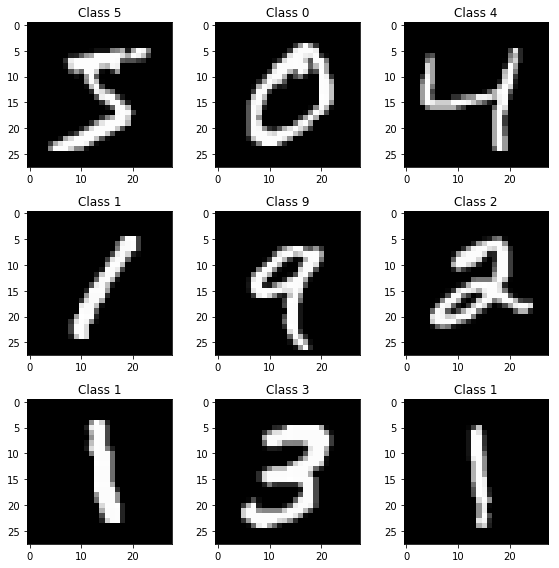

In [5]:
fig=plt.figure(figsize=(8, 8))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.title("Class {}".format(y_train[i]))
    plt.imshow(X_train[i], cmap='gray', interpolation='none')
plt.tight_layout()

The pixel values are gray scale between 0 and 255. It is almost always a good idea to perform some scaling of input values when using neural network models. Because the scale is well known and well behaved, we can very quickly normalize the pixel values to the range 0 and 1 by dividing each value by the maximum of 255.

In [6]:
# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255

Finally, the output variable is an integer from 0 to 9. As this is a multi-class classification problem we need to one hot encoding of the class values, transforming the vector of class integers into a binary matrix.

We can easily do this using the built-in np_utils.to_categorical() helper function in Keras.

In [7]:
# one hot encode outputs and save original classes
print(y_train.shape)
print(y_test.shape)
print(y_train[:10])
y_train_classes = y_train.copy()
y_test_classes = y_test.copy()
y_train = np_utils.to_categorical(y_train_classes)
y_test = np_utils.to_categorical(y_test_classes)
num_classes = y_test.shape[1]
print(y_train.shape)
print(y_test.shape)
print(y_train[:3])

(60000,)
(10000,)
[5 0 4 1 9 2 1 3 1 4]
(60000, 10)
(10000, 10)
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


## Feed forward network

The training dataset is structured as a 3-dimensional array of (instance, image width and image height). Our neural-network is going to take a single vector for each training example, so we need to reshape the input so that each 28x28 image becomes a single 784 dimensional vector.

We can do this transform easily using the reshape() function on the NumPy array. We can also reduce our memory requirements by forcing the precision of the pixel values to be 32 bit, the default precision used by Keras anyway.

In [8]:
# flatten 28*28 images to a 784 vector for each image
num_pixels = X_train.shape[1] * X_train.shape[2]
X_train_FF = X_train.reshape(X_train.shape[0], num_pixels).astype('float32')
X_test_FF = X_test.reshape(X_test.shape[0], num_pixels).astype('float32')
print(X_train_FF.shape)
print(X_test_FF.shape)

(60000, 784)
(10000, 784)


We use a simple network with a single hidden layer with the same number of neurans as input features. A softmax activation function is used on the output layer to turn the outputs into probability-like values and allow one class of the 10 to be selected as the model’s output prediction. Logarithmic loss is used as the loss function (called categorical_crossentropy in Keras) and the efficient ADAM gradient descent algorithm is used to learn the weights.

In [9]:
# define baseline model
def create_feed_forward_model():
    # create model
    model = Sequential()
    model.add(Dense(num_pixels, input_dim=num_pixels, kernel_initializer='normal', activation='relu'))
    model.add(Dense(num_classes, kernel_initializer='normal', activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [10]:
# build the model
model_FF = create_feed_forward_model()
print(model_FF.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 784)               615440    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                7850      
Total params: 623,290
Trainable params: 623,290
Non-trainable params: 0
_________________________________________________________________
None


Setup callback for tensor board logging, saving weights and early stopping. To start tensorboard, change to the folder containing the logs directory and run:

tensorboard --logdir=logs/

In [11]:
tf_callback_ff= TensorBoard(log_dir="logs/keras_mnist_ff/{}".format(time()), 
                                            histogram_freq=1, write_graph=True, write_images=True)
checkpointer_ff = ModelCheckpoint(filepath='Keras MNIST Recognition.FF.1.Model.Best.hdf5', 
                               verbose=1, save_best_only=True)
earlystopping_ff = EarlyStopping(monitor='val_acc', min_delta=0, patience=5, verbose=1, mode='auto')

Instructions for updating:
Use the retry module or similar alternatives.


Fit the model

In [12]:
history = model_FF.fit(X_train_FF, y_train, validation_data=(X_test_FF, y_test), epochs=10, 
                       batch_size=200, verbose=2, callbacks=[tf_callback_ff, checkpointer_ff, earlystopping_ff])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
 - 4s - loss: 0.2749 - acc: 0.9225 - val_loss: 0.1394 - val_acc: 0.9583

Epoch 00001: val_loss improved from inf to 0.13943, saving model to Keras MNIST Recognition.FF.1.Model.Best.hdf5
Epoch 2/10
 - 4s - loss: 0.1117 - acc: 0.9681 - val_loss: 0.1008 - val_acc: 0.9692

Epoch 00002: val_loss improved from 0.13943 to 0.10076, saving model to Keras MNIST Recognition.FF.1.Model.Best.hdf5
Epoch 3/10
 - 4s - loss: 0.0712 - acc: 0.9793 - val_loss: 0.0808 - val_acc: 0.9759

Epoch 00003: val_loss improved from 0.10076 to 0.08082, saving model to Keras MNIST Recognition.FF.1.Model.Best.hdf5
Epoch 4/10
 - 4s - loss: 0.0487 - acc: 0.9859 - val_loss: 0.0741 - val_acc: 0.9762

Epoch 00004: val_loss improved from 0.08082 to 0.07414, saving model to Keras MNIST Recognition.FF.1.Model.Best.hdf5
Epoch 5/10
 - 4s - loss: 0.0363 - acc: 0.9898 - val_loss: 0.0696 - val_acc: 0.9776

Epoch 00005: val_loss improved from 0.07414 to 0.06962, saving mod

Load back in the best weights

In [18]:
model_FF.load_weights('Keras MNIST Recognition.FF.1.Model.Best.hdf5')

Final evaluation of the model

In [19]:
score_model(model_FF, X_test_FF, y_test)

Test score: 0.06117515921080485
Test accuracy: 0.9821
Baseline Error: 1.79%


Plot accuracy and loss for train / test sets to see if more epochs would have helped and to ensure that we don't start overfitting.

Here we should probably have stopped after 4 epochs!

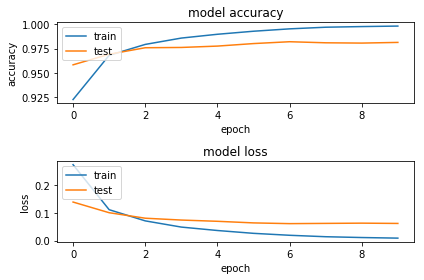

In [20]:
plot_model_accuracy_loss(history)

### Inspect the output
Manually inspect the output to check everything looks as expected

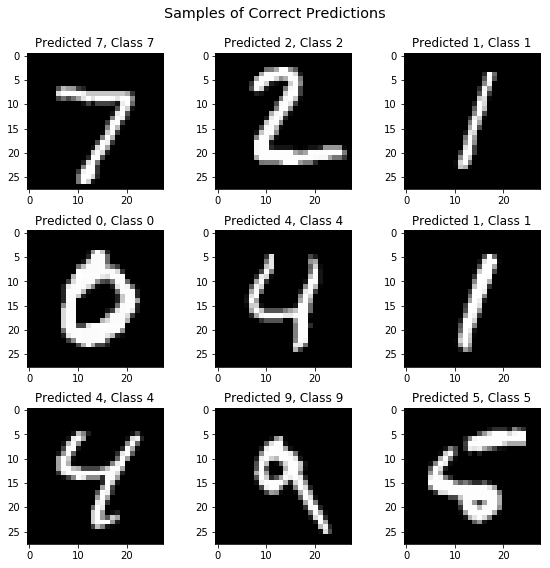

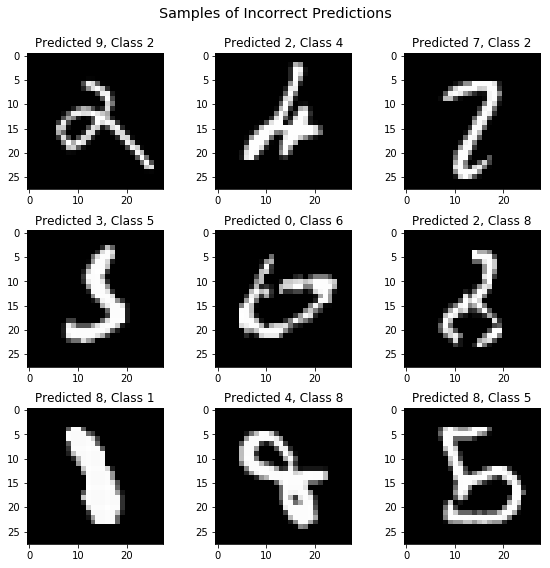

In [21]:
plot_sample_predictions(model_FF, X_test, X_test_FF, y_test_classes)

## Convolutional Neural Network
In Keras, the layers used for two-dimensional convolutions expect pixel values with the dimensions [width][height][pixels].

In the case of RGB, the pixel dimension would be 3 for the red, green and blue components and it would be like having 3 image inputs for every color image. In the case of MNIST where the pixel values are gray scale, the pixel dimension is set to 1.

In [22]:
# reshape to be [samples][pixels][width][height]
X_train_CNN = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_test_CNN = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')
print(X_train_CNN.shape)
print(X_test_CNN.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


We create a simple CNN with the following layers:

* The first hidden layer is a convolutional layer called a Convolution2D. The layer has 32 feature maps of size 5×5 and a rectifier activation function. This is the input layer, expecting images with the structure outline above [width][height][pixels].
* Next we define a pooling layer that takes the max called MaxPooling2D. It is configured with a pool size of 2×2.
* The next layer is a regularization layer using dropout called Dropout. It is configured to randomly exclude 20% of neurons in the layer in order to reduce overfitting.
* Next is a layer that converts the 2D matrix data to a vector called Flatten. It allows the output to be processed by standard fully connected layers.
* Next a fully connected layer with 128 neurons and rectifier activation function.
* Finally, the output layer has 10 neurons for the 10 classes and a softmax activation function to output probability-like predictions for each class.

In [23]:
def create_cnn_model():
    # create model
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(5, 5), input_shape=(28, 28, 1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax', name="Output"))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [24]:
# build the model
model_CNN = create_cnn_model()
print(model_CNN.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               589952    
_________________________________________________________________
Output (Dense)               (None, 10)                1290      
Total params: 592,074
Trainable params: 592,074
Non-trainable params: 0
_________________________________________________________________
None

In [25]:
tf_callback_cnn = keras.callbacks.TensorBoard(log_dir="logs/keras_mnist_cnn/{}".format(time()), 
                                              histogram_freq=1, write_graph=True, write_images=True)
checkpointer_cnn = ModelCheckpoint(filepath='Keras MNIST Recognition.CNN.1.Model.Best.hdf5', 
                               verbose=1, save_best_only=True)
earlystopping_cnn = EarlyStopping(monitor='val_acc', min_delta=0, patience=5, verbose=1, mode='auto')

Fit the model - note: tensorboard callback removed due to throwing an error.

In [26]:
history = model_CNN.fit(X_train_CNN, y_train, validation_data=(X_test_CNN, y_test), epochs=10, 
                        batch_size=200, verbose=2, callbacks=[checkpointer_cnn, earlystopping_cnn]) #,tf_callback_cnn])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
 - 23s - loss: 0.2574 - acc: 0.9267 - val_loss: 0.0854 - val_acc: 0.9748

Epoch 00001: val_loss improved from inf to 0.08540, saving model to Keras MNIST Recognition.CNN.1.Model.Best.hdf5
Epoch 2/10
 - 22s - loss: 0.0798 - acc: 0.9763 - val_loss: 0.0533 - val_acc: 0.9828

Epoch 00002: val_loss improved from 0.08540 to 0.05332, saving model to Keras MNIST Recognition.CNN.1.Model.Best.hdf5
Epoch 3/10
 - 22s - loss: 0.0546 - acc: 0.9837 - val_loss: 0.0433 - val_acc: 0.9850

Epoch 00003: val_loss improved from 0.05332 to 0.04333, saving model to Keras MNIST Recognition.CNN.1.Model.Best.hdf5
Epoch 4/10
 - 22s - loss: 0.0422 - acc: 0.9870 - val_loss: 0.0384 - val_acc: 0.9879

Epoch 00004: val_loss improved from 0.04333 to 0.03840, saving model to Keras MNIST Recognition.CNN.1.Model.Best.hdf5
Epoch 5/10
 - 22s - loss: 0.0356 - acc: 0.9887 - val_loss: 0.0351 - val_acc: 0.9878

Epoch 00005: val_loss improved from 0.03840 to 0.03512, s

Load back in the best weights

In [18]:
model_CNN.load_weights('Keras MNIST Recognition.CNN.1.Model.Best.hdf5')

Final evaluation of the model

In [27]:
score_model(model_CNN, X_test_CNN, y_test)

Test score: 0.03483877602495486
Test accuracy: 0.9886
Baseline Error: 1.14%


Plot accuracy and loss for train / test sets to see if more epochs would have helped and to ensure that we don't start overfitting

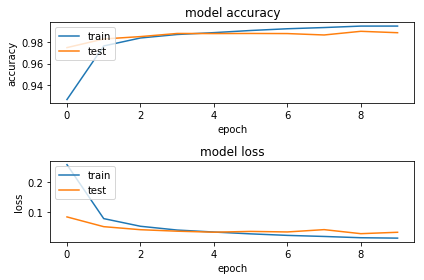

In [28]:
plot_model_accuracy_loss(history)

### Inspect the output
Manually inspect the output to check everything looks as expected

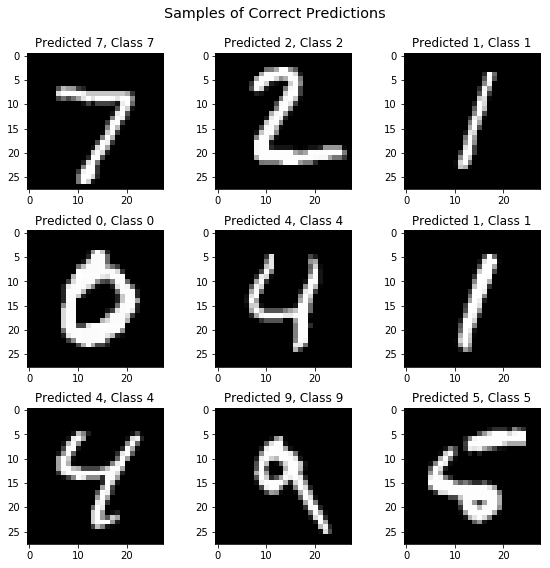

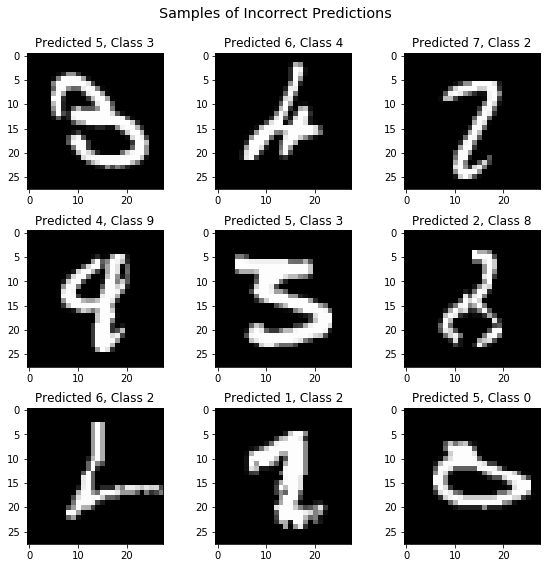

In [29]:
plot_sample_predictions(model_CNN, X_test, X_test_CNN, y_test_classes)

### Repeat with Data Augmentation
Data augmentation rotates, shears, zooms, etc the image so that the model learns to generalize and not remember specific data. 

First we show an example of data augmentation in action - using rotation

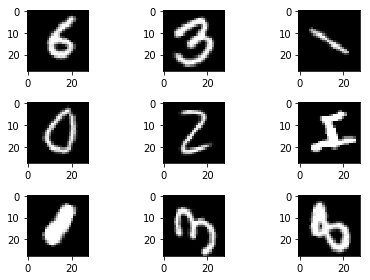

In [30]:
from keras.preprocessing.image import ImageDataGenerator
# define data preparation with features to test
datagen = ImageDataGenerator(rotation_range=90)
# fit parameters from data
datagen.fit(X_train_CNN)
# configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow(X_train_CNN, y_train, batch_size=9):
    # create a grid of 3x3 images
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].reshape(28, 28), cmap=plt.get_cmap('gray'))
    # show the plot
    plt.tight_layout()
    plt.show()
    break # loop one batch only

For the actual dataset, we create batches so that we use less memory and train our model faster. Here we are using a batch size of 64, so the model will take 64 images at a time and train on them.

In [31]:
gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3, height_shift_range=0.08, zoom_range=0.08)

test_gen = ImageDataGenerator()
batch_size = 64

In [34]:
train_generator = gen.flow(X_train_CNN, y_train, batch_size=batch_size)
test_generator = test_gen.flow(X_test_CNN, y_test, batch_size=batch_size)

In [35]:
tf_callback_cnn = keras.callbacks.TensorBoard(log_dir="logs/keras_mnist_cnn_a/{}".format(time()), 
                                              histogram_freq=1, write_graph=True, write_images=True)
checkpointer_cnn = ModelCheckpoint(filepath='Keras MNIST Recognition.CNN.2.Model.Best.hdf5', 
                               verbose=1, save_best_only=True)
earlystopping_cnn = EarlyStopping(monitor='val_acc', min_delta=0, patience=5, verbose=1, mode='auto')

In [36]:
model_CNN.fit_generator(train_generator, steps_per_epoch=60000//batch_size, epochs=10, validation_data=test_generator, 
                        validation_steps=10000//batch_size, verbose=2, callbacks=[checkpointer_cnn, earlystopping_cnn]) #,tf_callback_cnn])


Epoch 1/10
 - 27s - loss: 0.1098 - acc: 0.9658 - val_loss: 0.0297 - val_acc: 0.9894

Epoch 00001: val_loss improved from inf to 0.02965, saving model to Keras MNIST Recognition.CNN.2.Model.Best.hdf5
Epoch 2/10
 - 26s - loss: 0.0673 - acc: 0.9786 - val_loss: 0.0254 - val_acc: 0.9912

Epoch 00002: val_loss improved from 0.02965 to 0.02539, saving model to Keras MNIST Recognition.CNN.2.Model.Best.hdf5
Epoch 3/10
 - 26s - loss: 0.0578 - acc: 0.9822 - val_loss: 0.0251 - val_acc: 0.9914

Epoch 00003: val_loss improved from 0.02539 to 0.02512, saving model to Keras MNIST Recognition.CNN.2.Model.Best.hdf5
Epoch 4/10
 - 26s - loss: 0.0520 - acc: 0.9836 - val_loss: 0.0217 - val_acc: 0.9918

Epoch 00004: val_loss improved from 0.02512 to 0.02165, saving model to Keras MNIST Recognition.CNN.2.Model.Best.hdf5
Epoch 5/10
 - 26s - loss: 0.0475 - acc: 0.9854 - val_loss: 0.0259 - val_acc: 0.9911

Epoch 00005: val_loss did not improve
Epoch 6/10
 - 27s - loss: 0.0447 - acc: 0.9868 - val_loss: 0.0224 - v

In [37]:
model_CNN.load_weights('Keras MNIST Recognition.CNN.2.Model.Best.hdf5')

In [38]:
score_model(model_CNN, X_test_CNN, y_test)

Test score: 0.016377725926972925
Test accuracy: 0.9941
Baseline Error: 0.59%


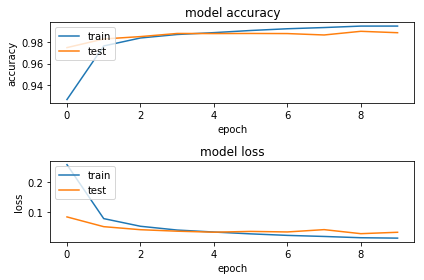

In [39]:
plot_model_accuracy_loss(history)

### Visualise The Trained Network
#### Feature Maps (Filters) for Convolutional Layer
By plotting the filters we can see what kind of features are being targeted.

Low level filters nearer the start of a network work as edge detectors, and as we go forther, they tend to capture high level concepts like objects and faces.

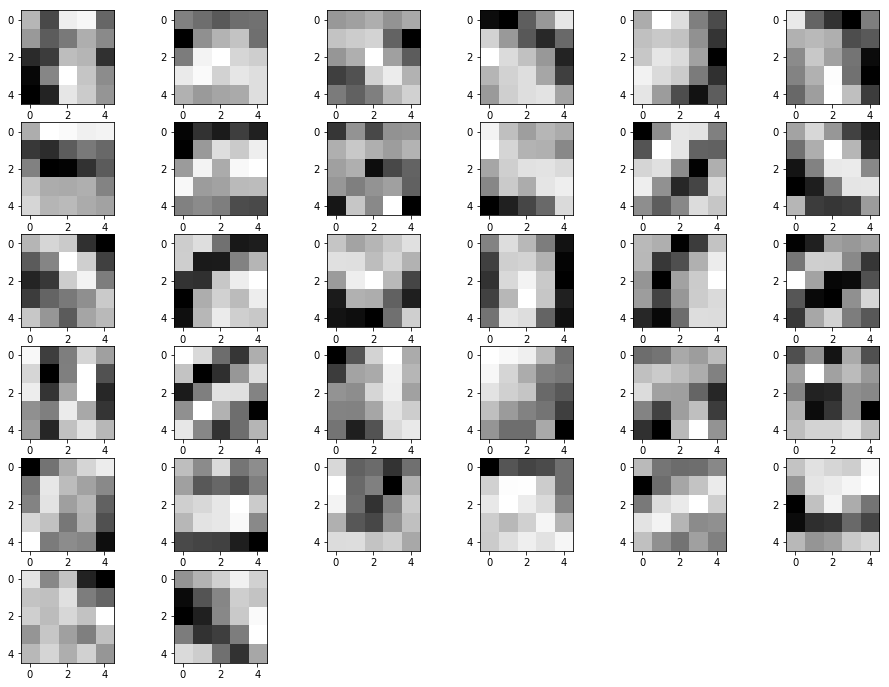

In [40]:
top_layer = model_CNN.layers[0]
fig=plt.figure(figsize=(16, 12))
for i in range(32):
    plt.subplot(6,6,i+1)
    plt.imshow(top_layer.get_weights()[0][:, :, :, i].squeeze(), cmap='gray')

#### Activation Maps
Generates the model input that maximizes the output of all filter_indices in the given layer_idx. This allows us to see what features / regions within the images are contributing to different classes being chosen.

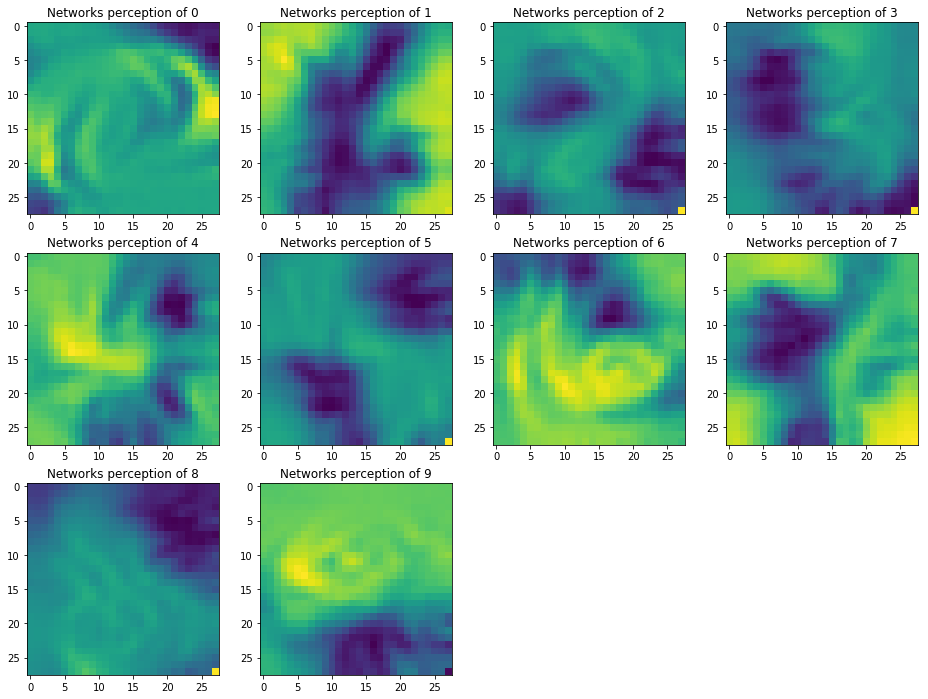

In [41]:
from vis.visualization import visualize_activation
from vis.utils import utils

# Utility to search for layer index by name.
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(model_CNN, 'Output')

# Swap softmax with linear
model_CNN.layers[layer_idx].activation = activations.linear
model_CNN = utils.apply_modifications(model_CNN)

# plot activations on inputs that will trigger a particular class.
fig=plt.figure(figsize=(16, 12))
for output_class_idx in np.arange(10):
    plt.subplot(3,4,output_class_idx+1)
    # Lets turn off verbose output this time to avoid clutter and just see the output.
    img = visualize_activation(model_CNN, layer_idx, filter_indices=output_class_idx, input_range=(0., 1.))
    #/plt.figure()
    plt.title('Networks perception of {}'.format(output_class_idx))
    plt.imshow(img[..., 0])

#### Saliency Maps
Highlights the salient image regions that contribute the most towards the output.

The concept of using saliency maps is pretty straight-forward – we compute the gradient of the output category with respect to the input image. This should tell us how the output category value changes with respect to a small change in the input image pixels. All the positive values in the gradients tell us that a small change to that pixel will increase the output value. Hence, visualizing these gradients, which are the same shape as the image, should provide some intuition of attention.

https://arxiv.org/pdf/1312.6034v2.pdf

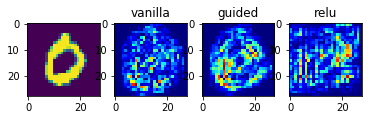

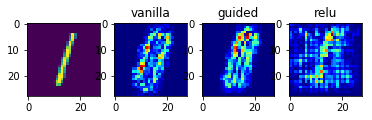

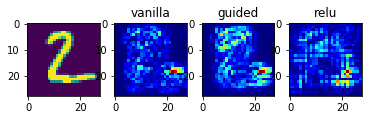

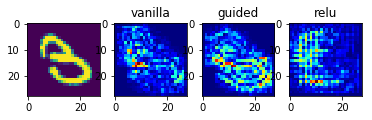

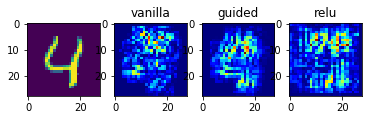

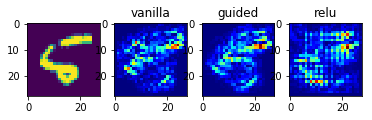

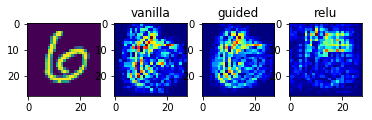

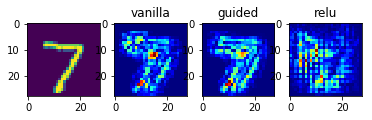

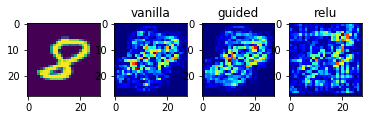

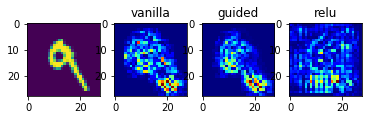

In [42]:
from vis.visualization import visualize_saliency
from vis.utils import utils

# This corresponds to the Dense linear layer.
for output_class_idx in np.arange(10): 
    indices = np.where(y_test[:, output_class_idx] == 1.)[0]
    idx = indices[0]
    f, ax = plt.subplots(1, 4)
    ax[0].imshow(X_test[idx])
 
    for i, modifier in enumerate([None, 'guided', 'relu']):
        grads = visualize_saliency(model_CNN, layer_idx, filter_indices=output_class_idx, 
        seed_input=X_test_CNN[idx], backprop_modifier=modifier)
        if modifier is None:
            modifier = 'vanilla'
        ax[i+1].set_title(modifier) 
        ax[i+1].imshow(grads, cmap='jet')

#### Gradient based Class Activations Maps
Class activation maps, or grad-CAM, is another way of visualizing what our model looks at while making predictions. Instead of using gradients with respect to the output, grad-CAM uses penultimate Convolutional layer output. This is done to utilize the spacial information that is being stored in the penultimate layer.

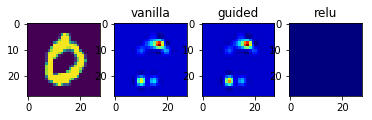

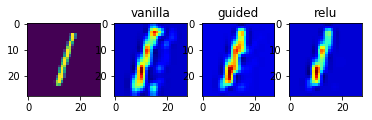

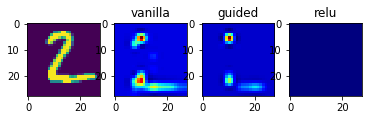

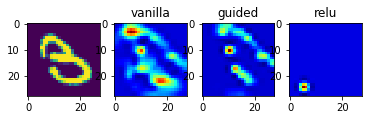

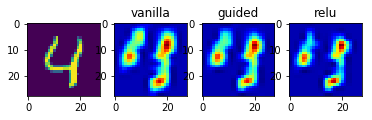

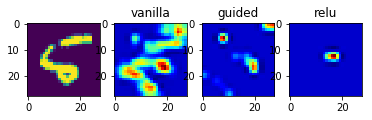

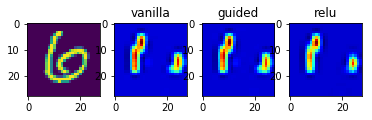

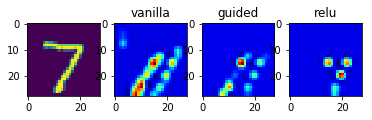

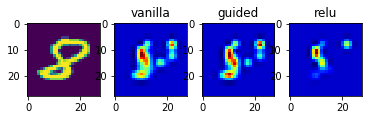

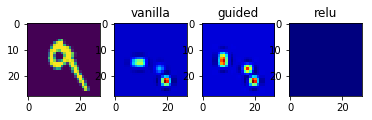

In [43]:
from vis.visualization import visualize_cam

# This corresponds to the Dense linear layer.
for output_class_idx in np.arange(10): 
    indices = np.where(y_test[:, output_class_idx] == 1.)[0]
    idx = indices[0]
    f, ax = plt.subplots(1, 4)
    ax[0].imshow(X_test[idx])
 
    for i, modifier in enumerate([None, 'guided', 'relu']):
        grads = visualize_cam(model_CNN, layer_idx, filter_indices=output_class_idx, 
        seed_input=X_test_CNN[idx], backprop_modifier=modifier) 
        if modifier is None:
            modifier = 'vanilla'
        ax[i+1].set_title(modifier) 
        ax[i+1].imshow(grads, cmap='jet')

## More Advanced CNN Network
A more advanced convolutional network might add additional convolutional, max pooling and fully connected layers for example:

* Convolutional layer with 30 feature maps of size 5×5.
* Pooling layer taking the max over 2*2 patches.
* Convolutional layer with 15 feature maps of size 3×3.
* Pooling layer taking the max over 2*2 patches.
* Dropout layer with a probability of 20%.
* Flatten layer.
* Fully connected layer with 128 neurons and rectifier activation.
* Fully connected layer with 50 neurons and rectifier activation.
* Output layer.

In [44]:
# define the larger model
def create_improved_cnn_model():
    # create model
    model = Sequential()
    model.add(Conv2D(30, (5, 5), input_shape=(1, 28, 28), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(15, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

Here We don't evaluate this model further, but would expect improvements.

## Transfer Learning
We can try transfer learning on a proven architecture in this case VGG16. There are two methods we will use:
* First we will just remove the top layers (as we don't want the original 1000 classes) and then train a seperate network based upon the output of the trimmed model.
* Secondly we will remove the top layers, add our own layers and then retrain the network. We will freeze a number of the initial layers so they aren't retrained.

Note that we don't necessarily expect better results in this case as the domains are different and possibly not transferable. This is more to demonstrate the concept.

Before getting to the modelling part we need to convert the images to the correct format shape including greyscale to RGB. 
We will also need to resize the images to match the input to the underlying network that we are using.

In [45]:
from keras.applications.vgg16 import preprocess_input
from skimage.transform import resize

X_train_VGG=X_train.reshape(60000,28,28,1).repeat(3,3)
X_train_VGG = np.array([resize(X_train_VGG[i], (112, 112, 3)) 
                        for i in range(0, len(X_train_VGG))]).astype('float32')
X_train_VGG=preprocess_input(X_train_VGG)

X_test_VGG=X_test.reshape(10000,28,28,1).repeat(3,3)
X_test_VGG = np.array([resize(X_test_VGG[i], (112, 112, 3)) 
                        for i in range(0, len(X_test_VGG))]).astype('float32')
X_test_VGG=preprocess_input(X_test_VGG)

print(X_train_VGG.shape)
print(X_test_VGG.shape)

C:\Applications\Miniconda3\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(60000, 112, 112, 3)
(10000, 112, 112, 3)


Import additional packages

In [46]:
from keras.applications.vgg16 import VGG16, decode_predictions

Load the VGG26 model and automatically removes the output layers (include_top=False). We will either use this to get the embeddings and train a seperate model on this, or to append new layers for our custom labels.

In [47]:
model = VGG16(weights='imagenet', include_top=False, input_shape = (112, 112, 3))
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 112, 112, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 112, 112, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 112, 112, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 56, 56, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 56, 56, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 56, 56, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 28, 28, 128)       0         
__________

### Example 1: Train a seperate MLP from the VGG embedding
We will pass the data through VGG network with the top layers removed to get an embedding for the dataset based upon VGG 16. We then train a seperate model using the embedding as input and the original labels as output. For our test set we can then do similar - first use the original network to get the embedding and then predit using our newly trained network.

This gives pretty poor results (better then a baseline model of 10% accuracy). Improvements might include removing more layers so we have a more abstract embedding representation, using a different secondary model, ...

Get embeddings for the train and test sets

In [48]:
# Extracting features from the train dataset using the VGG16 pre-trained model
features_train=model.predict(X_train_VGG)
# Extracting features from the train dataset using the VGG16 pre-trained model
features_test=model.predict(X_test_VGG)

In [49]:
#features_train.shape
features_train.shape[1:]
#features = np.squeeze(features)

(3, 3, 512)

Train a new model with the embedding as input and predicting the corresponding label

In [50]:
model_embedding = Sequential()
model_embedding.add(Conv2D(filters=100, kernel_size=2, input_shape=features_train.shape[1:]))
model_embedding.add(Dropout(0.4))
model_embedding.add(GlobalAveragePooling2D())
model_embedding.add(Dropout(0.3))
model_embedding.add(Dense(10, activation='softmax'))
model_embedding.summary()

model_embedding.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='Keras MNIST Recognition.Transfer.1.Model.Best.hdf5', 
                               verbose=1, save_best_only=True)
#model.fit(features, y_train, batch_size=50, epochs=50,
#          validation_split=0.2, callbacks=[checkpointer],
#          verbose=2, shuffle=True)
history = model_embedding.fit(features_train, y_train,batch_size=batch_size,epochs=10,shuffle=True,
                            verbose=2,validation_data=(features_test, y_test), callbacks=[checkpointer])



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 2, 2, 100)         204900    
_________________________________________________________________
dropout_2 (Dropout)          (None, 2, 2, 100)         0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 100)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1010      
Total params: 205,910
Trainable params: 205,910
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
 - 11s - loss: 1.9411 - acc: 0.3150 - val_loss: 1.5373 - val_acc: 0.4517

E

In [51]:
# load the weights that yielded the best validation accuracy
model_embedding.load_weights('Keras MNIST Recognition.Transfer.1.Model.Best.hdf5')

score_model(model_embedding, features_test, y_test)

Test score: 0.8647224519729614
Test accuracy: 0.7
Baseline Error: 30.00%


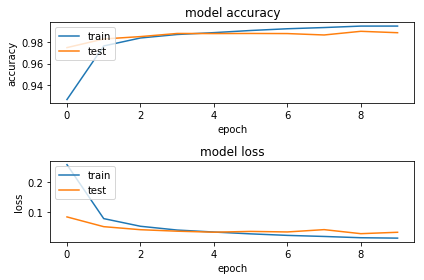

In [52]:
plot_model_accuracy_loss(history)

### Example 2: Add additional layers and retrain
Here we use vgg16 as a feature extractor. The output layer in a vgg16 is a softmax activation with 1000 categories. We remove this and some of the other top level layers and replace them with a softmax layer of 10 categories in addition to a couple of others. 

We then retrain the model, but freezing the weights of initial layers so they are not updated. This is because the first few layers capture universal features like curves and edges that are also relevant to our new problem. We want to keep those weights intact and we will get the network to focus on learning dataset-specific features in the subsequent layers.

In [58]:
# Adding our new layers 
top_layers = model.output
top_layers = Flatten(input_shape=model.output_shape[1:])(top_layers)
top_layers = Dense(num_classes, activation="relu",input_shape=(num_classes,))(top_layers)
top_layers = Dropout(0.5)(top_layers)
top_layers = Dense(num_classes, activation="relu",input_shape=(num_classes,))(top_layers)
top_layers = Dense(num_classes, activation="softmax")(top_layers)

# Add top layers on top of freezed (not re-trained) layers of VGG16
model_final = Model(input = model.input, output = top_layers)

C:\Applications\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  # Remove the CWD from sys.path while we load stuff.


In [59]:
from keras.optimizers import SGD

# set the first 19 layers (up to the last conv block)
# to non-trainable (weights will not be updated)
for layer in model_final.layers[:19]:
    layer.trainable = False

# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
model_final.compile(loss='binary_crossentropy',
              optimizer=SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

In [60]:
print(model_final.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 112, 112, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 112, 112, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 112, 112, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 56, 56, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 56, 56, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 56, 56, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 28, 28, 128)       0         
__________

In [62]:
# Fit the model training only non frozen layers. We use 3 epochs as this is only a demo and this is slow!
checkpointer = ModelCheckpoint(filepath='Keras MNIST Recognition.Transfer.2.Model.Best.hdf5', 
                               verbose=1, save_best_only=True)
earlystopping_transfer = EarlyStopping(monitor='val_acc', min_delta=0, patience=5, verbose=1, mode='auto')
history = model_final.fit(X_train_VGG, y_train,batch_size=batch_size,epochs=3,shuffle=True, 
                          verbose=2,validation_data=(X_test_VGG, y_test), callbacks=[checkpointer, earlystopping_transfer])

Train on 60000 samples, validate on 10000 samples
Epoch 1/3
 - 6774s - loss: 0.3269 - acc: 0.9000 - val_loss: 0.3251 - val_acc: 0.9000

Epoch 00001: val_loss improved from inf to 0.32508, saving model to Keras MNIST Recognition.Transfer.2.Model.Best.hdf5
Epoch 2/3
 - 6989s - loss: 0.3251 - acc: 0.9000 - val_loss: 0.3251 - val_acc: 0.9000

Epoch 00002: val_loss improved from 0.32508 to 0.32508, saving model to Keras MNIST Recognition.Transfer.2.Model.Best.hdf5
Epoch 3/3
 - 6615s - loss: 0.3251 - acc: 0.9000 - val_loss: 0.3251 - val_acc: 0.9000

Epoch 00003: val_loss improved from 0.32508 to 0.32507, saving model to Keras MNIST Recognition.Transfer.2.Model.Best.hdf5


In [64]:
# load the weights that yielded the best validation accuracy
model_final.load_weights('Keras MNIST Recognition.Transfer.2.Model.Best.hdf5')

score_model(model_final, X_test_VGG, y_test)

Test score: 0.3250714271068573
Test accuracy: 0.9000000356674195
Baseline Error: 10.00%


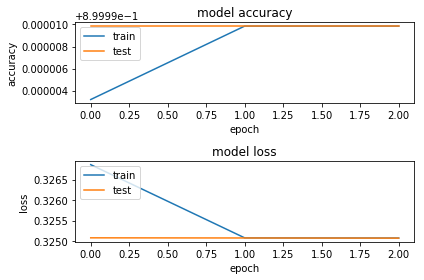

In [65]:
plot_model_accuracy_loss(history)